In [1]:
!git checkout craft-update 

M	craft_manywell.ipynb
Already on 'craft-update'
Your branch is up to date with 'origin/craft-update'.


In [2]:
from annealed_flow_transport.train import run_experiment
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from annealed_flow_transport.many_well_plotting import plot, plot_marginal_pair
from annealed_flow_transport.densities import ManyWell
from annealed_flow_transport.resampling import log_effective_sample_size

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 100

/homes/lim24/miniconda3/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-01 10:40:52.104912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 10:40:52.105002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-01 10:40:52.105011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned ab

In [100]:
original_setup = True # whether to run Alex's original config, or a config that is more similar to FAB's setup.
if original_setup:
    from configs.many_well_original import get_config
    exp_config = get_config()
    exp_config.n_samples_plotting = 100
else:
    from configs.many_well import get_config
    exp_config = get_config()
    exp_config.craft_num_iters = 1000
    exp_config.report_step = 100

In [7]:
exp_config.num_temps, exp_config.flow_config.type

(11, 'SplineInverseAutoregressiveFlow')

In [8]:
n_mill_target_eval = exp_config.craft_batch_size*exp_config.craft_num_iters*exp_config.num_temps*exp_config.mcmc_config.hmc_num_leapfrog_steps/1e6
n_mill_target_eval

44.0

  0%|                                                   | 0/200 [00:00<?, ?it/s]

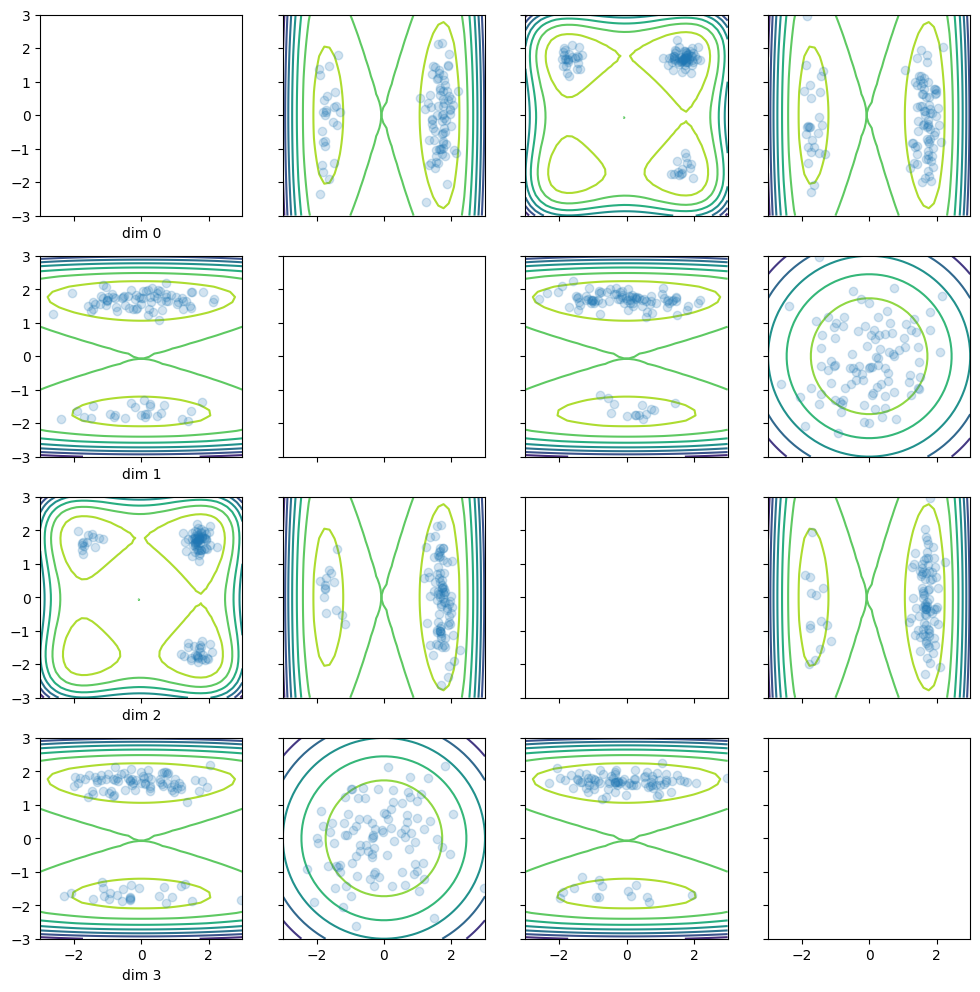

  0%|▏                                          | 1/200 [00:15<50:37, 15.26s/it]

effective sample size of 0.9999998807907104
Step 0: Free energy -157.56015014648438 Log Normalizer estimate 163.17323303222656


 16%|██████▉                                   | 33/200 [00:20<00:28,  5.93it/s]

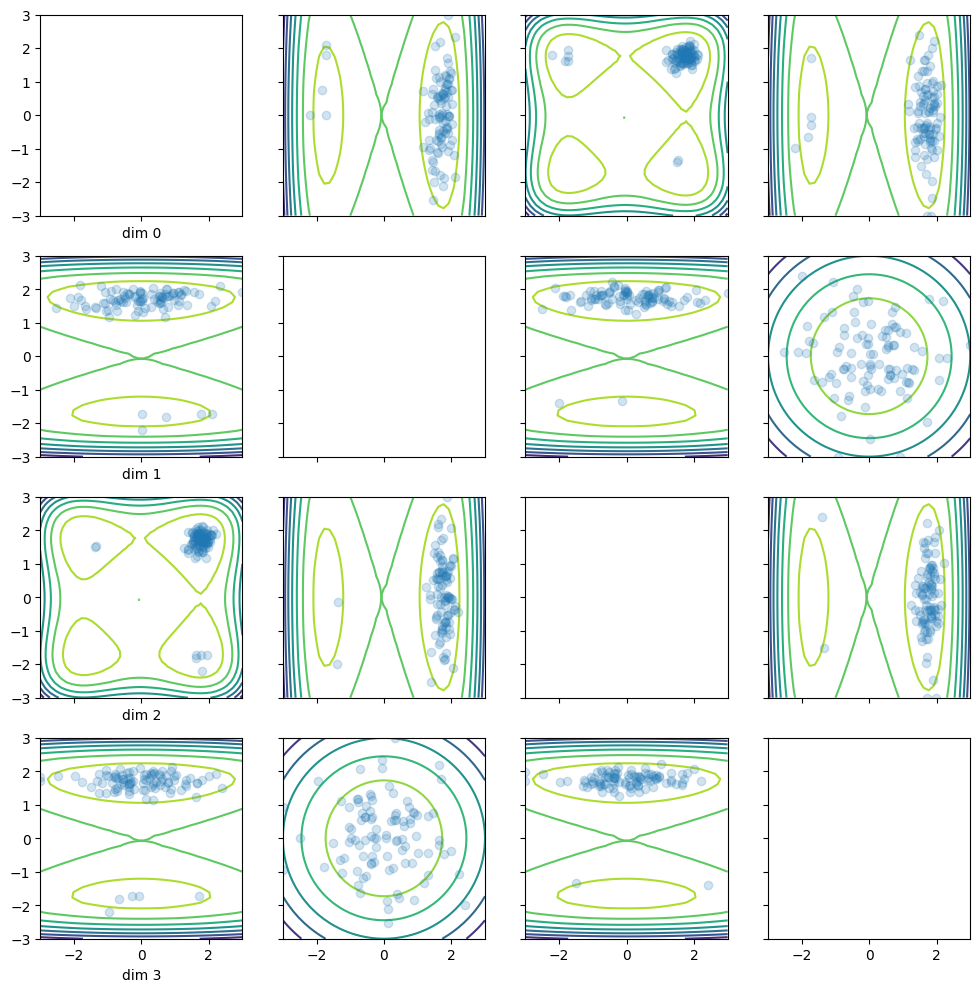

 17%|███████▏                                  | 34/200 [00:32<10:15,  3.71s/it]

effective sample size of 0.9999998807907104
Step 33: Free energy -162.53961181640625 Log Normalizer estimate 165.6494140625


 33%|█████████████▊                            | 66/200 [00:38<00:22,  5.92it/s]

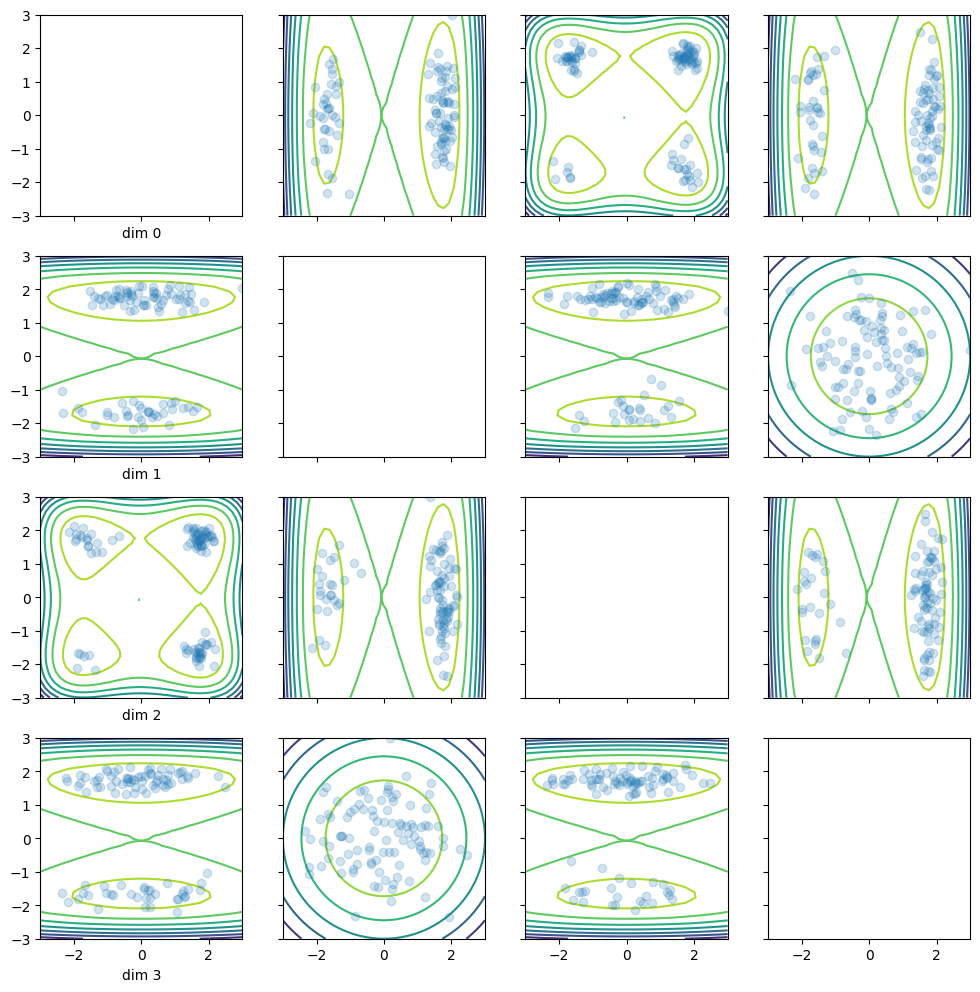

 34%|██████████████                            | 67/200 [00:50<08:14,  3.72s/it]

effective sample size of 0.7085193991661072
Step 66: Free energy -162.3423309326172 Log Normalizer estimate 164.40687561035156


 50%|████████████████████▊                     | 99/200 [00:55<00:17,  5.87it/s]

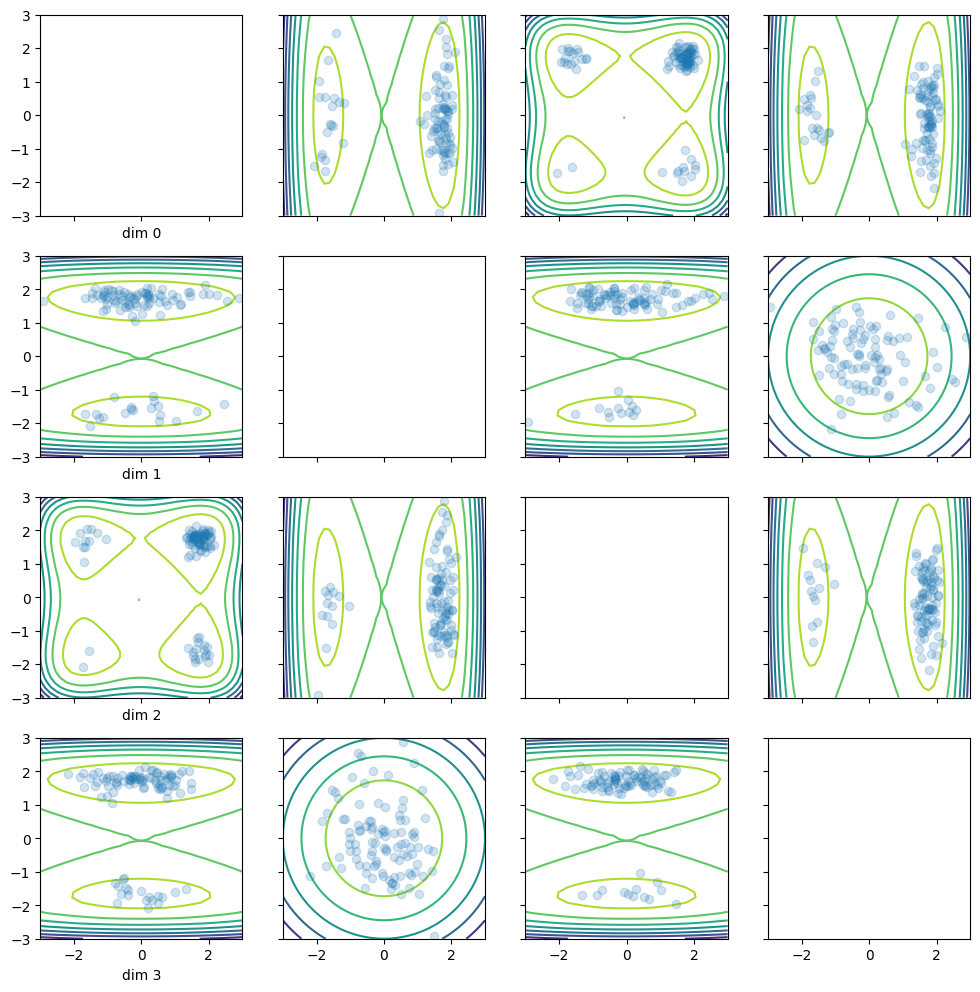

 50%|████████████████████▌                    | 100/200 [01:07<06:13,  3.73s/it]

effective sample size of 0.9999998807907104
Step 99: Free energy -162.94732666015625 Log Normalizer estimate 164.5690155029297


 66%|███████████████████████████              | 132/200 [01:13<00:11,  5.86it/s]

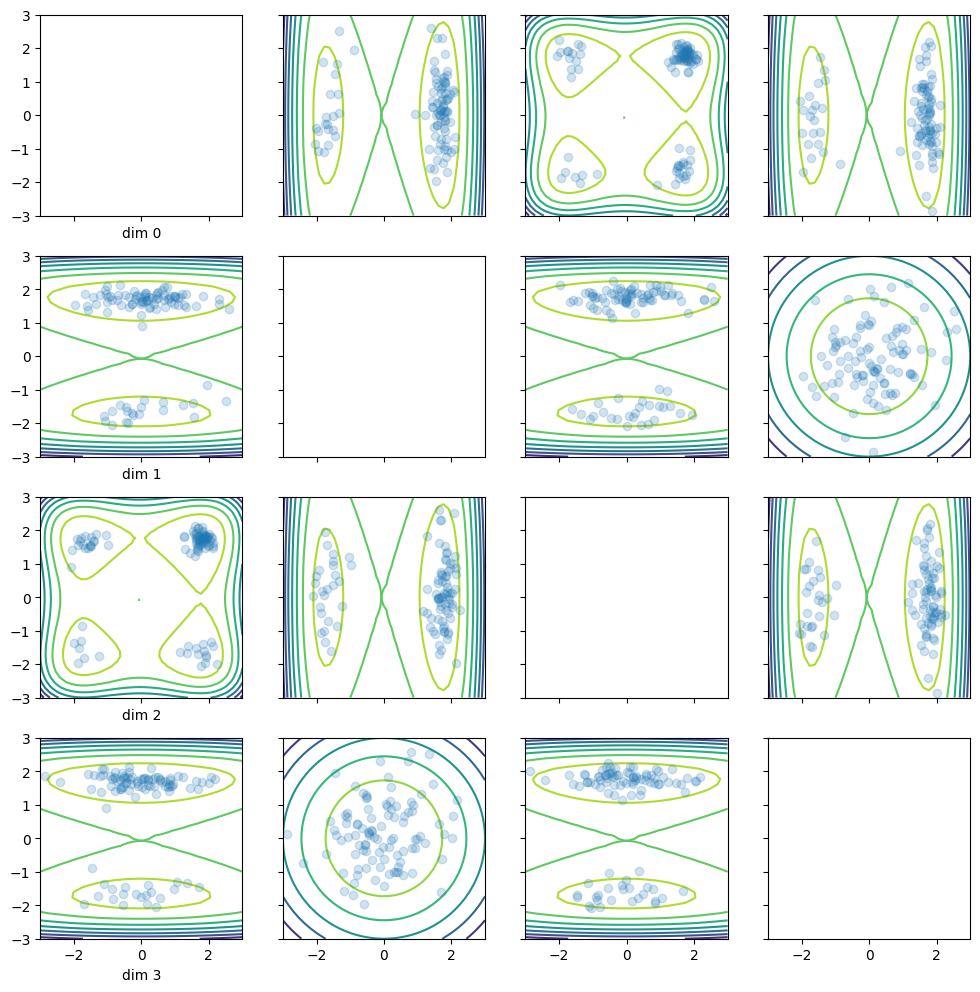

 66%|███████████████████████████▎             | 133/200 [01:25<04:11,  3.76s/it]

effective sample size of 0.45261350274086
Step 132: Free energy -163.80670166015625 Log Normalizer estimate 165.20750427246094


 82%|█████████████████████████████████▊       | 165/200 [01:30<00:05,  5.87it/s]

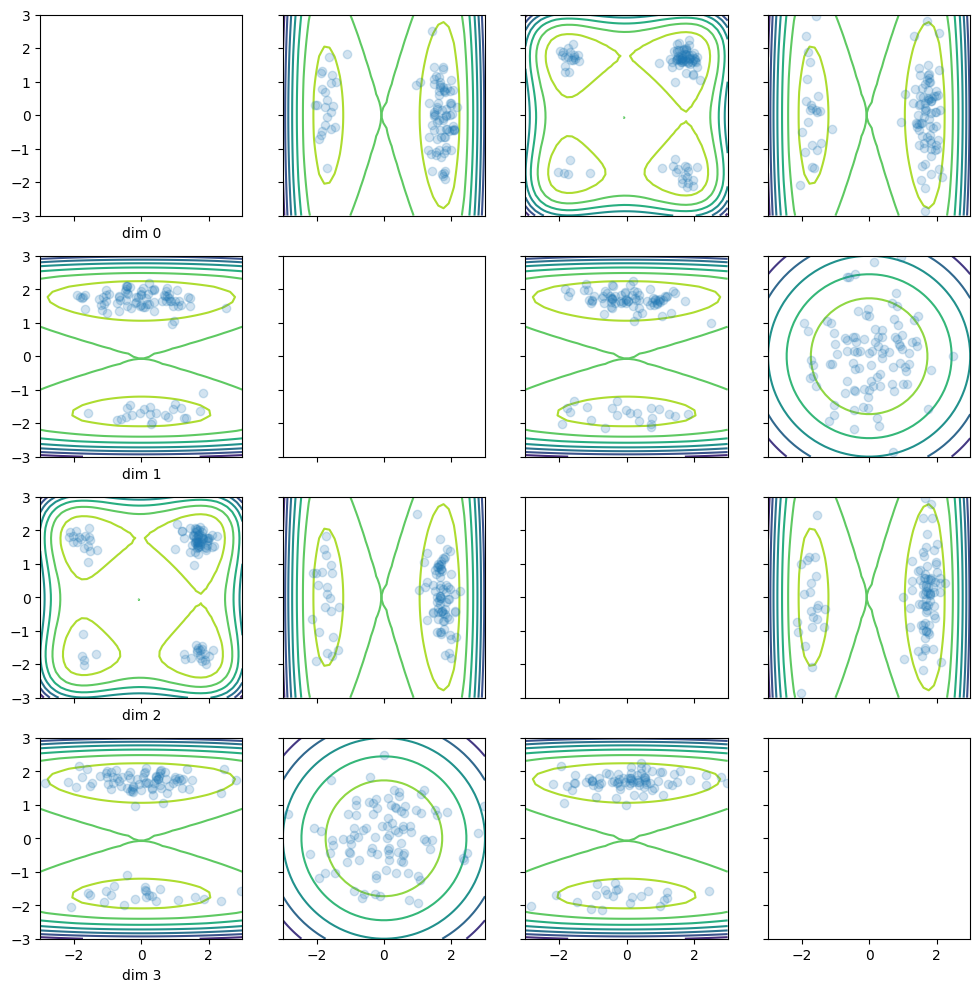

 83%|██████████████████████████████████       | 166/200 [01:42<02:05,  3.70s/it]

effective sample size of 0.9042111039161682
Step 165: Free energy -163.5054931640625 Log Normalizer estimate 164.63546752929688


 99%|████████████████████████████████████████▌| 198/200 [01:48<00:00,  5.89it/s]

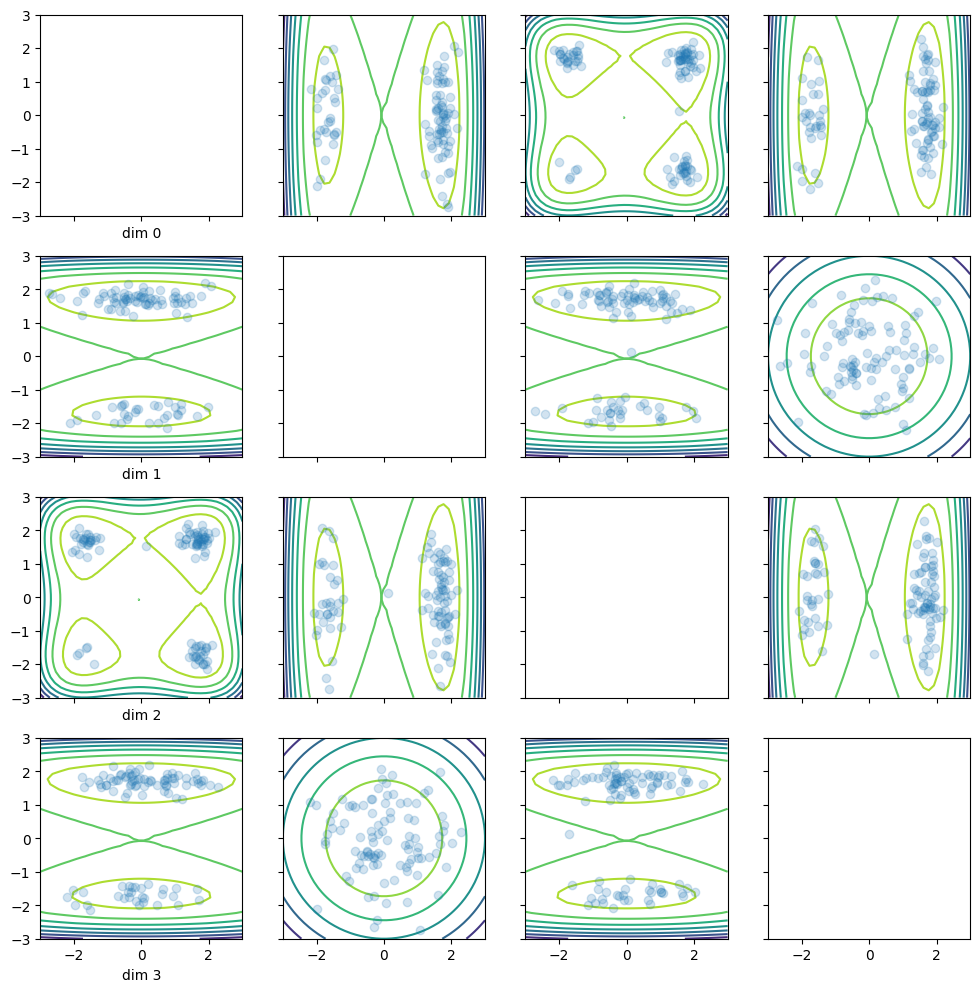

100%|█████████████████████████████████████████| 200/200 [02:00<00:00,  1.66it/s]

effective sample size of 0.3280690610408783
Step 198: Free energy -163.63990783691406 Log Normalizer estimate 164.69268798828125


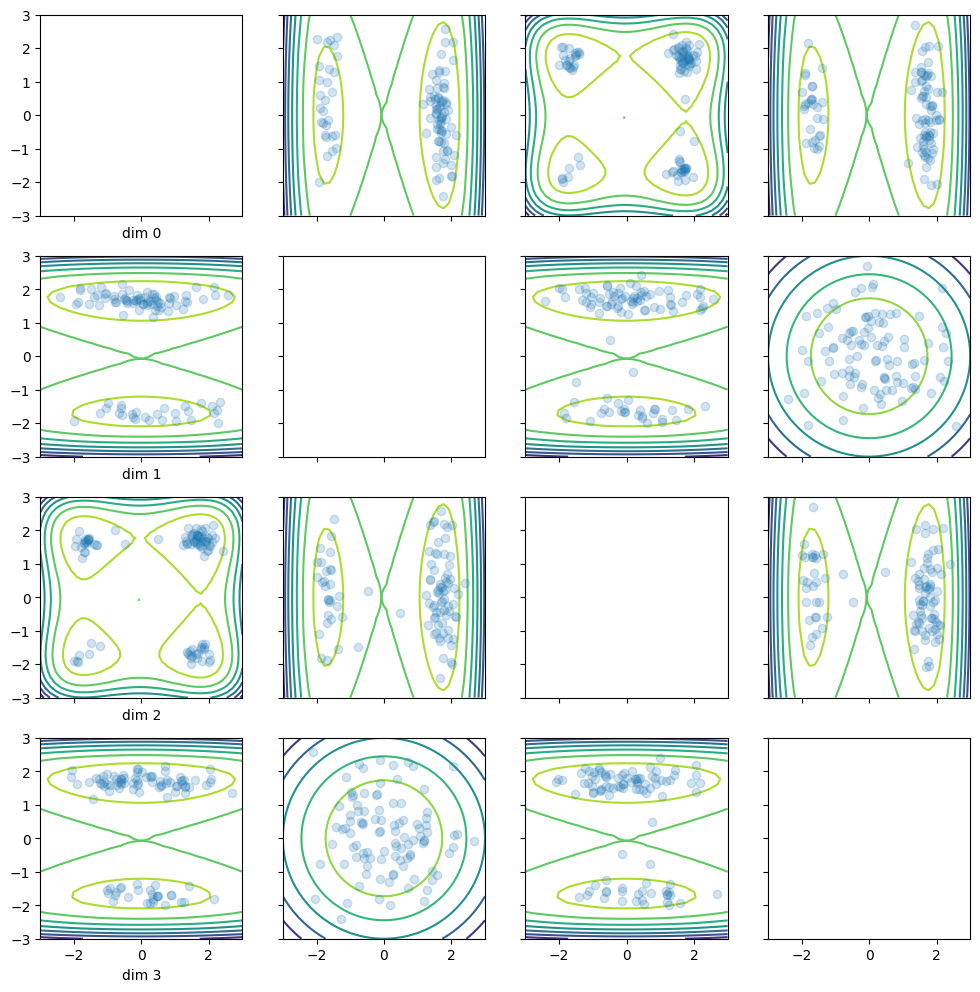

In [9]:
if original_setup:
    !rm checkpoint_craft_mw_original
else:
    !rm checkpoint_craft_mw
results = run_experiment(exp_config)

# Preliminary Evaluation

In [10]:
target_density = ManyWell(exp_config.final_config.density, (32,))

In [11]:
# n_plotting_samples = 1000
# plot(results.test_samples[:n_plotting_samples], target_density.evaluate_log_density, 8)

In [12]:
results.log_normalizer_estimate, target_density.log_Z

(Array(164.35098, dtype=float32), 164.6956753197969)

In [13]:
results.test_log_weights

Array([-7.087114 , -9.601942 , -7.5110145, ..., -7.993871 , -6.0865912,
       -5.4714103], dtype=float32)

In [14]:
1 / jnp.sum(jax.nn.softmax(results.test_log_weights) ** 2) / results.test_log_weights.shape[0]

Array(0.31544295, dtype=float32)

In [15]:
jnp.exp(log_effective_sample_size(results.test_log_weights)) / results.test_log_weights.shape[0]

Array(0.31544307, dtype=float32)

# Proper evaluation

# Load model

In [227]:
from evaluation import evaluate_many_well, load_checkpoint, make_forward_pass_func, \
    make_get_ess, make_get_resample_info, get_flow_init_params

In [228]:
if original_setup:
    filename = 'checkpoint_craft_mw_original'
else:
    filename = "checkpoint_craft_mw"
transition_params = load_checkpoint(filename)

### Evalation of full craft

In [229]:
exp_config.use_resampling = True
exp_config.use_markov = True

In [1]:
eval_batch_size = int(1e4) # exp_config.batch_size

forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

NameError: name 'make_forward_pass_func' is not defined

In [231]:
eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

In [232]:
eval_info['ess']

Array([0.9999999 , 0.91766155, 0.9101566 , 0.9142771 , 0.9148101 ,
       0.9091368 , 0.9212672 , 0.9999999 , 0.91721314, 0.9999999 ,
       0.9109147 , 0.9162892 , 0.9112771 , 0.91821265, 0.92256135,
       0.9999999 , 0.31676376, 0.91245806, 0.92297024, 0.9271344 ],      dtype=float32)

In [233]:
jnp.sum(eval_info['ess'] > 0.999)

Array(4, dtype=int32)

In [234]:
jnp.unique(eval_info['log_w'][1]).shape

(8969,)

Text(0.5, 1.0, 'effective sample size')

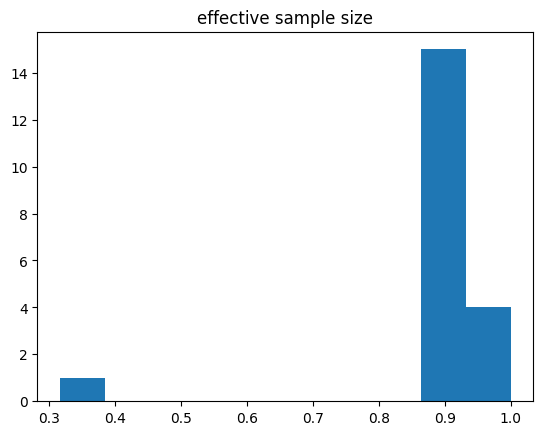

In [235]:
plt.hist(eval_info['ess'])
plt.title("effective sample size")

### Inspect samples

In [236]:
i = 0
double_well_marginal = eval_info['x'][i][:, jnp.arange(16)*2]
double_well_marginal.shape

(10000, 16)

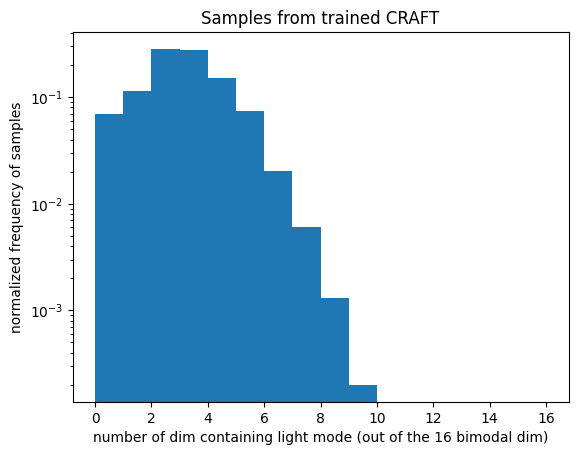

In [237]:
double_well_light_marginal_per_dim = (double_well_marginal < -1.) & (double_well_marginal > -2.1)

# Plot rate of sampling fainter modes.
n_light_mode = jnp.sum(double_well_light_marginal_per_dim, axis=-1)
plt.hist(n_light_mode, density=True, log=True, bins=jnp.arange(17))
plt.xlabel("number of dim containing light mode (out of the 16 bimodal dim)")
plt.ylabel("normalized frequency of samples")
plt.title("Samples from trained CRAFT")
plt.show()

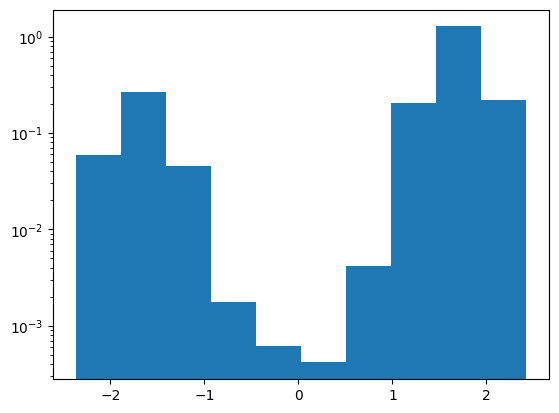

In [212]:
_ = plt.hist(double_well_marginal[:, 14], density=True, log=True)
plt.show()

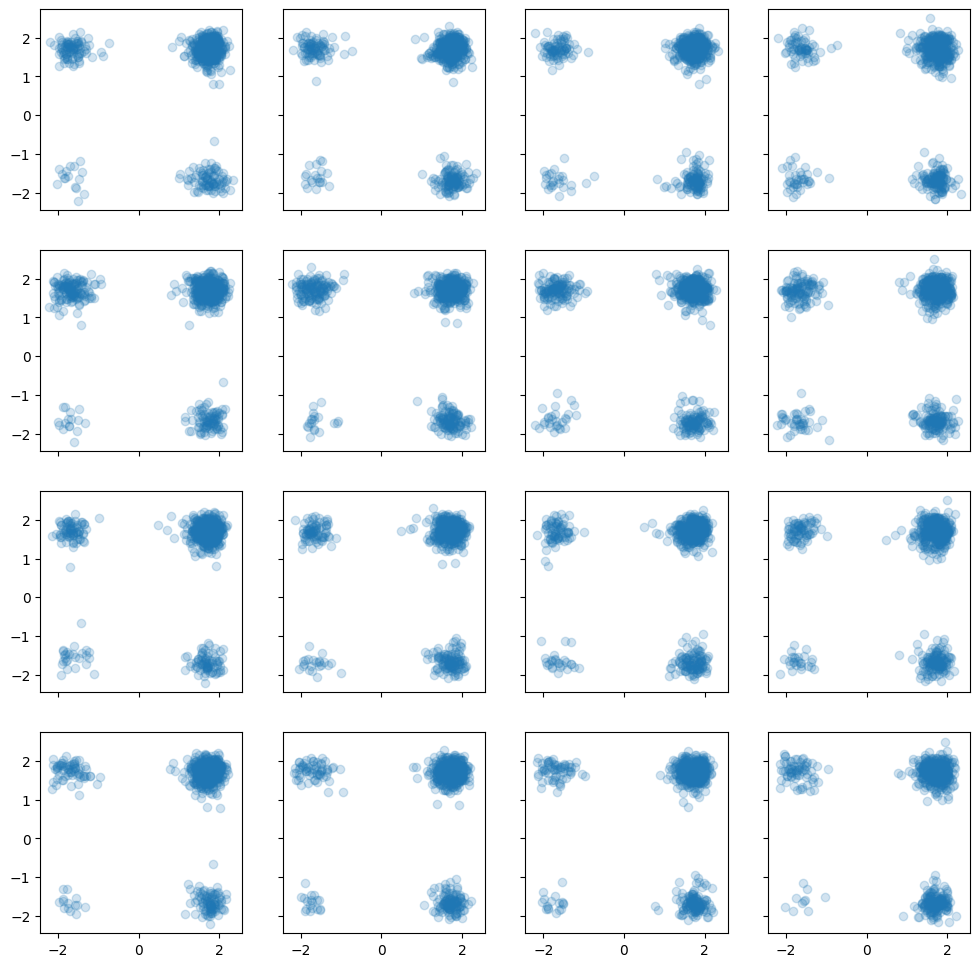

In [213]:
# Get marginal for the first two being light.
marginal_condition = (double_well_light_marginal_per_dim[:, 0] == True) & (double_well_light_marginal_per_dim[:, 1] == True)
marginal_samples = double_well_marginal[marginal_condition]
n_rows = 4
fig, axs = plt.subplots(n_rows, n_rows, sharex=True, sharey=True, figsize=(n_rows * 3, n_rows * 3))
i_start = 2
j_start = i_start + n_rows
for i in range(n_rows):
    for j in range(n_rows):
        plot_marginal_pair(marginal_samples, ax=axs[i, j], marginal_dims=(i + i_start, j + j_start), bounds=(-3, 3),
                           alpha=0.2)
plt.show()

# Eval inital model

In [214]:
transition_params = get_flow_init_params(exp_config)

In [220]:
forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

In [221]:
eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

Text(0.5, 1.0, 'Samples from initial CRAFT')

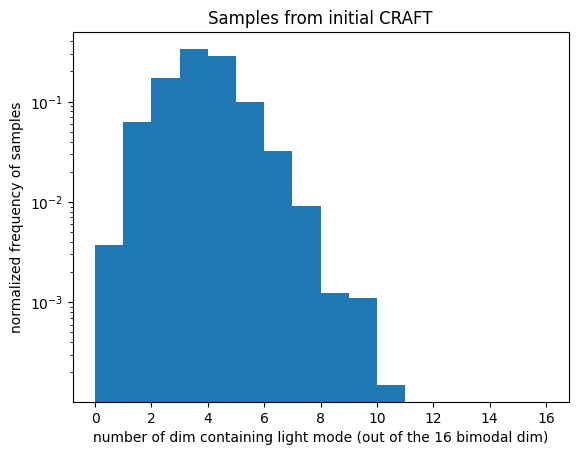

In [225]:
i = 0
double_well_marginal = eval_info['x'][i][:, jnp.arange(16)*2]

double_well_light_marginal_per_dim = (double_well_marginal < -1.) & (double_well_marginal > -2.1)

# Plot rate of sampling fainter modes.
n_light_mode = jnp.sum(double_well_light_marginal_per_dim, axis=-1)
plt.hist(n_light_mode, density=True, log=True, bins=jnp.arange(17))
plt.xlabel("number of dim containing light mode (out of the 16 bimodal dim)")
plt.ylabel("normalized frequency of samples")
plt.title("Samples from initial CRAFT")

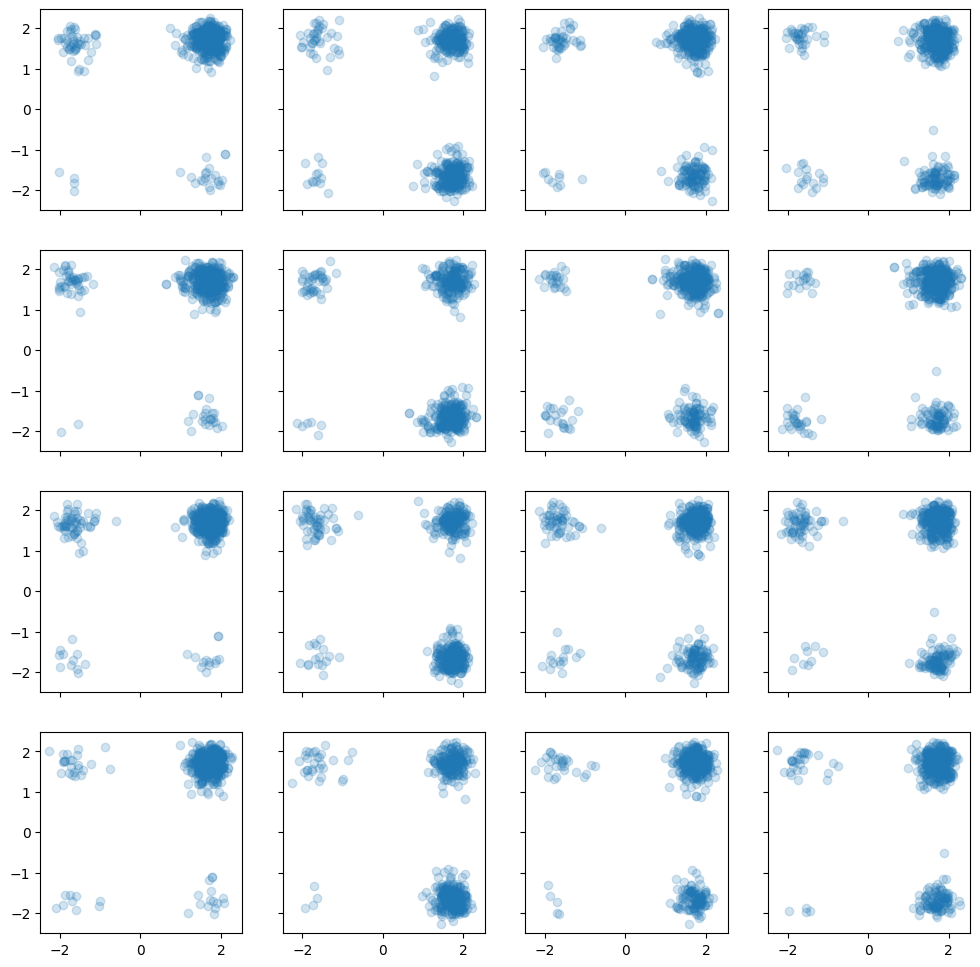

In [218]:
# Get marginal for the first two being light.
marginal_condition = (double_well_light_marginal_per_dim[:, -1] == True) & (double_well_light_marginal_per_dim[:, -2] == True)
marginal_samples = double_well_marginal[marginal_condition]
n_rows = 4
fig, axs = plt.subplots(n_rows, n_rows, sharex=True, sharey=True, figsize=(n_rows * 3, n_rows * 3))
i_start = 2
j_start = i_start + n_rows
for i in range(n_rows):
    for j in range(n_rows):
        plot_marginal_pair(marginal_samples, ax=axs[i, j], marginal_dims=(i + i_start, j + j_start), bounds=(-3, 3),
                           alpha=0.2)
plt.show()

# Without resampling

In [ ]:
exp_config.use_resampling = False
exp_config.use_markov = True

eval_batch_size = exp_config.batch_size
if original_setup:
    filename = 'checkpoint_craft_mw_original'
else:
    filename = "checkpoint_craft_mw"
transition_params = load_checkpoint(filename)
forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

eval_info['ess']

In [ ]:
eval_info['log_w']

# Evaluate resampling

In [13]:
exp_config.use_resampling = True
exp_config.use_markov = True
eval_batch_size = exp_config.batch_size

In [14]:
get_resample_info_fn = make_get_resample_info(config=exp_config, transition_params=transition_params,
                                        eval_batch_size=eval_batch_size)

In [15]:
resample_info = get_resample_info_fn(jax.random.PRNGKey(0))
log_w = resample_info['log_weights']
ess = jnp.exp(log_effective_sample_size(log_w)) / log_w.shape[0]
print(ess)

0.73968863


In [16]:
resample_info

{'n_unique_samples_hist': [1209,
  1214,
  1187,
  1169,
  1142,
  1044,
  923,
  790,
  1245,
  1152],
 'log_weights': Array([-7.919309 , -9.499626 , -8.013264 , ..., -6.906095 , -7.6029487,
        -8.689632 ], dtype=float32),
 'ess': [Array(0.9173008, dtype=float32),
  Array(0.8865997, dtype=float32),
  Array(0.8567174, dtype=float32),
  Array(0.81046724, dtype=float32),
  Array(0.7123037, dtype=float32),
  Array(0.5287206, dtype=float32),
  Array(0.3329029, dtype=float32),
  Array(0.2009167, dtype=float32),
  Array(0.91396475, dtype=float32),
  Array(0.73968863, dtype=float32)]}

In [17]:
for i, ess in enumerate(resample_info['ess']):
    ess_str = "{:.2f}".format(float(ess))
    print(f"Transport step {i+1}: ess of {ess_str}")
    if ess < exp_config.resample_threshold:
        print("**resampling occured**")

Transport step 1: ess of 0.92
Transport step 2: ess of 0.89
Transport step 3: ess of 0.86
Transport step 4: ess of 0.81
Transport step 5: ess of 0.71
Transport step 6: ess of 0.53
Transport step 7: ess of 0.33
Transport step 8: ess of 0.20
**resampling occured**
Transport step 9: ess of 0.91
Transport step 10: ess of 0.74


# Eval flow layer by layer

In [ ]:
exp_config.use_resampling, exp_config.use_markov
eval_batch_size = 10000

In [ ]:
get_ess_per_layer_fn = make_get_ess(config=exp_config, transition_params=transition_params,
                                        eval_batch_size=eval_batch_size)

In [ ]:
ess_per_step = get_ess_per_layer_fn(jax.random.PRNGKey(0))

In [ ]:
ess_per_step

In [ ]:
jnp.prod(jnp.stack(ess_per_step))

## Evaluation of flow only forward pass without resampling

In [ ]:
exp_config.use_resampling = False
exp_config.use_markov = False

In [ ]:
eval_batch_size = exp_config.batch_size
if original_setup:
    filename = 'checkpoint_craft_mw_original'
else:
    filename = "checkpoint_craft_mw"
transition_params = load_checkpoint(filename)
forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

In [ ]:
eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

In [ ]:
eval_info['ess']

In [ ]:
plot(eval_info['x'][0][0:200], target_density, 6)

### Evaluate first layer of the flow

In [ ]:
from evaluation import setup_basic_objects
import haiku as hk
from annealed_flow_transport.craft import craft_evaluation_loop, ParticleState, \
    flow_transport
from annealed_flow_transport import markov_kernel
from functools import partial

In [ ]:
config = exp_config
config.craft_batch_size = eval_batch_size
num_temps = config.num_temps

initial_sampler, log_density_initial, log_density_final, flow_func = \
    setup_basic_objects(config)

flow_forward_fn = hk.without_apply_rng(hk.transform(flow_func))
flow_apply = flow_forward_fn.apply
log_density_by_step = flow_transport.GeometricAnnealingSchedule(
    log_density_initial, log_density_final, num_temps)
markov_kernel_by_step = markov_kernel.MarkovTransitionKernel(
    config.mcmc_config, log_density_by_step, num_temps)

In [ ]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
initial_samples = initial_sampler(subkey, config.craft_batch_size,
                                    config.sample_shape)
flow_samples, log_det_jacs = flow_apply(jax.tree_map(lambda x: x[0], transition_params), initial_samples)

In [ ]:
flow_samples.shape, log_det_jacs.shape

In [ ]:
step = 1
log_density_values_current = log_density_by_step(step, flow_samples)
log_density_values_previous = log_density_by_step(step-1, initial_samples)

In [ ]:
log_w = log_density_values_current - (log_density_values_previous - log_det_jacs)

In [ ]:
jnp.exp(log_effective_sample_size(log_w)) / log_w.shape[0]

In [ ]:
plot(flow_samples[0:200], partial(log_density_by_step, 1), 4)